In [4]:
from skimage import io, color, data, draw, exposure, feature, filters, measure, morphology, util, segmentation
import numpy as np
import matplotlib.pyplot as plt
import scipy.fft as sft
import scipy.signal as sps
from PIL import Image

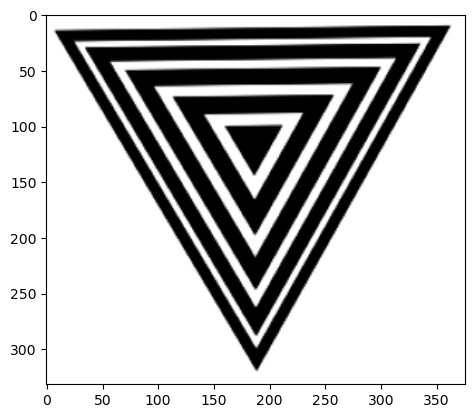

In [5]:
sticker = np.asarray(Image.open('triangle.png'))
imgplot = plt.imshow(sticker, cmap="gray")

In [6]:
sticker.shape

(332, 376, 4)

(332, 376)


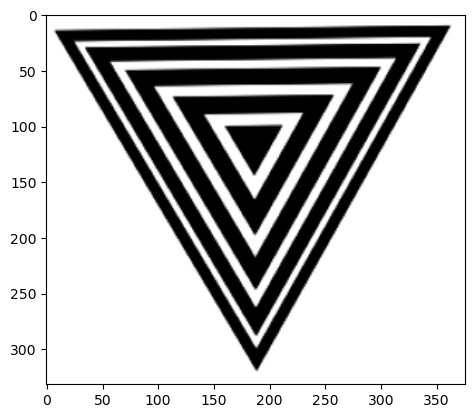

In [7]:
gray_sticker = color.rgba2rgb(sticker)
gray_sticker = color.rgb2gray(gray_sticker)
plt.imshow(sticker, cmap="gray")
print(gray_sticker.shape)

In [18]:
def display_img(img, dft):
    """
    Display the image img both as 2D and 3D
    Param: img (a float image with values between 0 and 1)
    """
    I, J = img.shape
    fig = plt.figure(figsize=(8, 4))
    ax1 = fig.add_subplot(1, 3, 1)
    ax1.imshow(img, cmap='viridis')
    ax2 = fig.add_subplot(1, 3, 2, projection='3d')
    j = np.arange(0, J, 1)
    i = np.arange(0, I, 1)
    jj, ii = np.meshgrid(j, i)
    ax2.plot_surface(jj, ii, img, rstride=1, cstride=1, cmap='viridis', antialiased=False)
    ax3 = fig.add_subplot(1, 3, 3)
    inv = np.real(sft.ifft2(dft))
    ax3.imshow(inv, cmap='gray')

In [9]:
def get_dft_magnitude(dft):
    """
    Returns the log10-scaled magnitude of the DFT shifted to have low frequencies at the center
    Param: dft (the complex DFT of an image)
    """   
    dft_mag = np.log10(1 + np.abs(sft.fftshift(dft)))
    return dft_mag

In [28]:
def display_by_search_box(sticker, image):
    # Define the size of the search box
    box_height = sticker.shape[0]
    box_width = sticker.shape[1]
    
    # Calculate the required padding
    pad_height = 0 if image.shape[0] % box_height == 0 else box_height - image.shape[0] % box_height
    pad_width = 0 if image.shape[1] % box_width == 0 else box_width - image.shape[1] % box_width
    
    # Apply padding to the image
    padded_image = np.pad(image, ((0, pad_height), (0, pad_width)), mode='constant', constant_values=1)
    
    # Initialize an array to store the DFT results
    dft_results = []
    
    # Loop over the padded image
    for y in range(0, padded_image.shape[0], box_height):
        for x in range(0, padded_image.shape[1], box_width):
            # Extract the search box from the padded image
            search_box = padded_image[y:y + box_height, x:x + box_width]
    
            # Compute the DFT of the search box
            search_box_dft = sft.fft2(search_box)
    
            # Store the DFT result
            dft_results.append(search_box_dft)
    
    i, j = 1, 1
    for dft in dft_results:
        dft_mag = get_dft_magnitude(dft)
        # Compute the correlation coefficient between the magnitude spectra
        correlation_matrix = np.corrcoef(sticker_dft_mag.flatten(), dft_mag.flatten())
        correlation = correlation_matrix[0, 1]
        print(f'Correlation coefficient between frequency magnitudes for the {i} box: {correlation}')
        i += 1
        
        # Compute the MSE between the two magnitude spectra
        mse = np.mean((dft_mag - sticker_dft_mag) ** 2)
        print(f'Mean Squared Error between magnitude spectra for the {j} box: {mse}')
        j += 1
        
        display_img(dft_mag, dft)

    return (dft_results, padded_image)


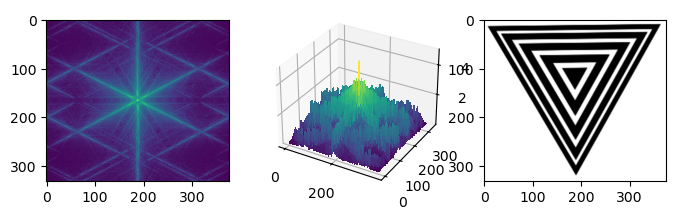

In [21]:
sticker_dft = sft.fft2(gray_sticker)
# Let's calculate the magnitude
mag = np.abs(sticker_dft)
lmag = np.log10(1 + mag)
sticker_dft_mag = get_dft_magnitude(sticker_dft)
display_img(sticker_dft_mag, sticker_dft)

## Try with test1

(960, 1708)


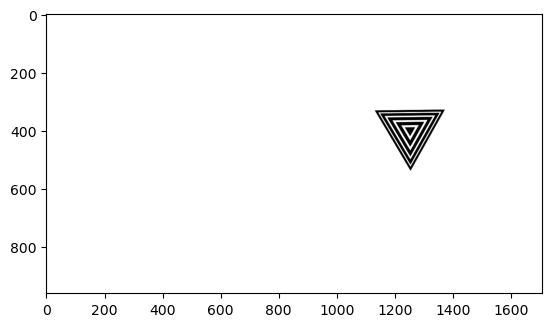

In [22]:
# Load the image
image = io.imread('test1.png', as_gray=True)

plt.imshow(image, cmap="gray")

print(image.shape)

Correlation coefficient between frequency magnitudes for the 1 box: 0.023191346847976878
Mean Squared Error between magnitude spectra for the 1 box: 0.6681819603766297
Correlation coefficient between frequency magnitudes for the 2 box: 0.023191346847976878
Mean Squared Error between magnitude spectra for the 2 box: 0.6681819603766297
Correlation coefficient between frequency magnitudes for the 3 box: 0.023191346847976878
Mean Squared Error between magnitude spectra for the 3 box: 0.6681819603766297
Correlation coefficient between frequency magnitudes for the 4 box: 0.6564454590413462
Mean Squared Error between magnitude spectra for the 4 box: 0.22369908807697603
Correlation coefficient between frequency magnitudes for the 5 box: 0.023191346847976878
Mean Squared Error between magnitude spectra for the 5 box: 0.6681819603766297
Correlation coefficient between frequency magnitudes for the 6 box: 0.023191346847976878
Mean Squared Error between magnitude spectra for the 6 box: 0.6681819603

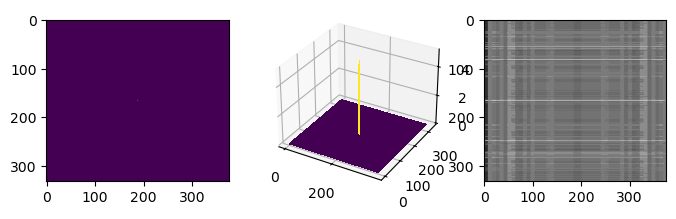

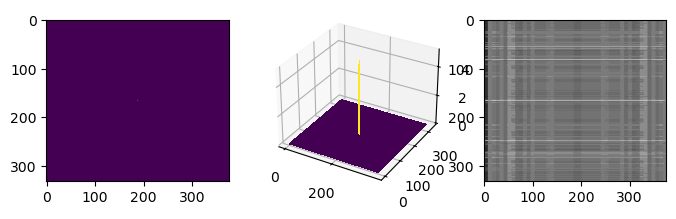

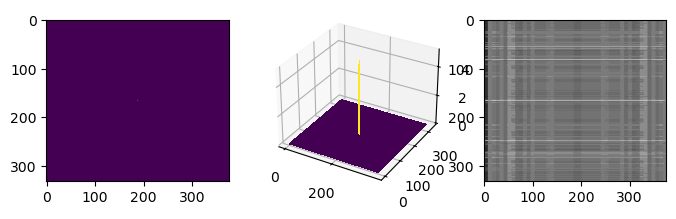

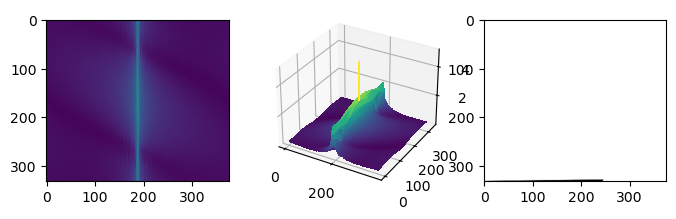

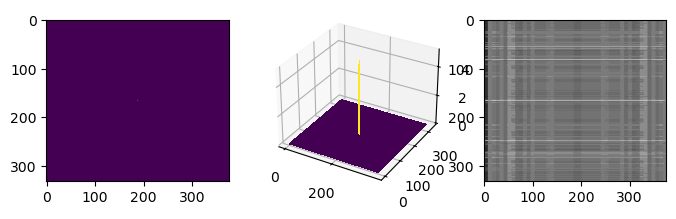

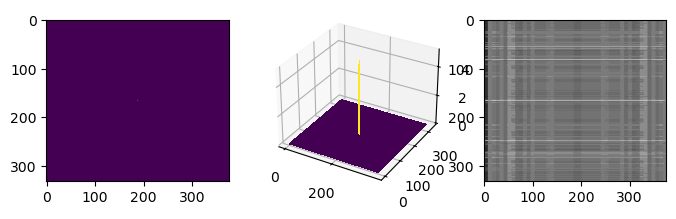

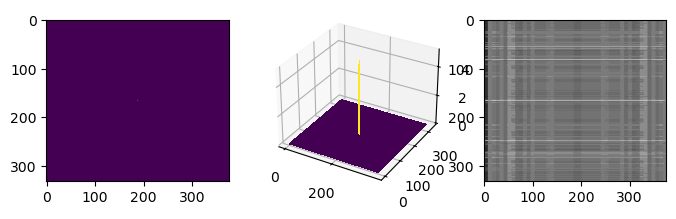

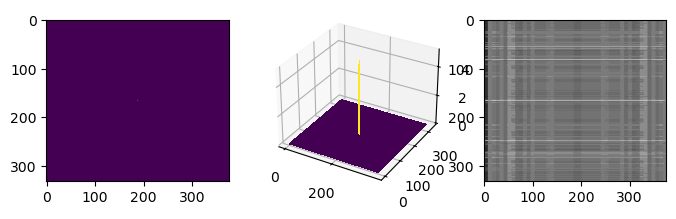

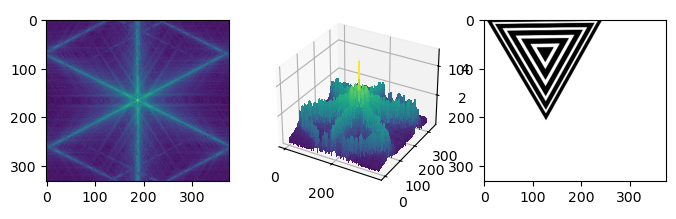

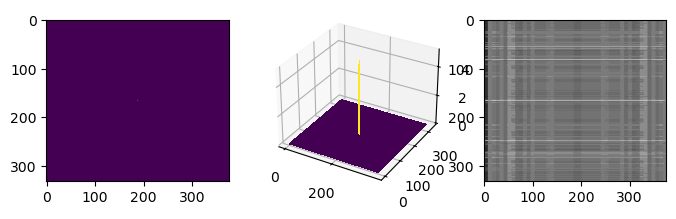

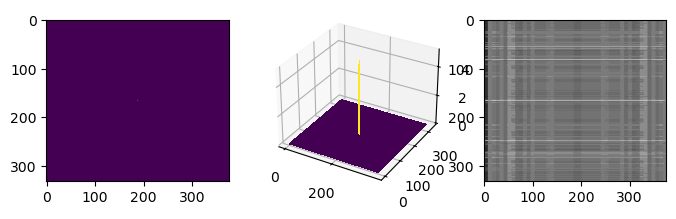

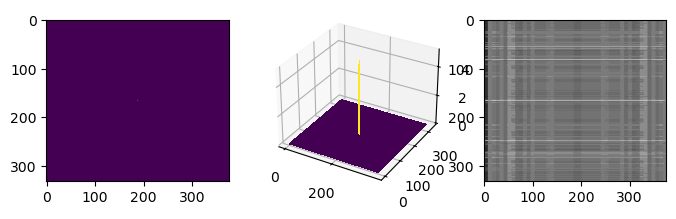

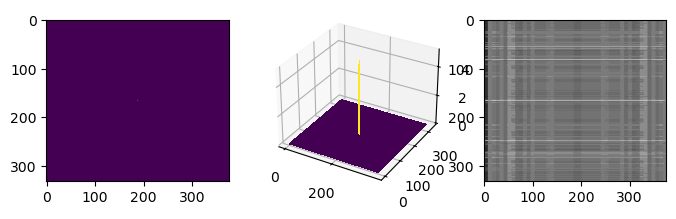

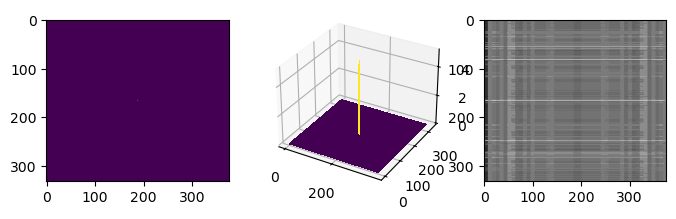

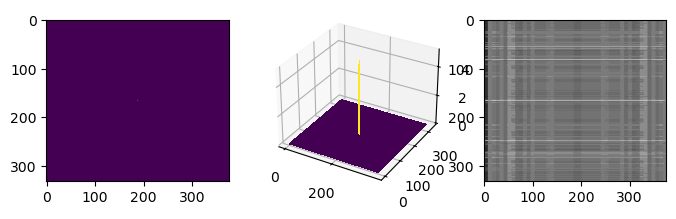

In [30]:
dft1, padded_image1 = display_by_search_box(gray_sticker, image)

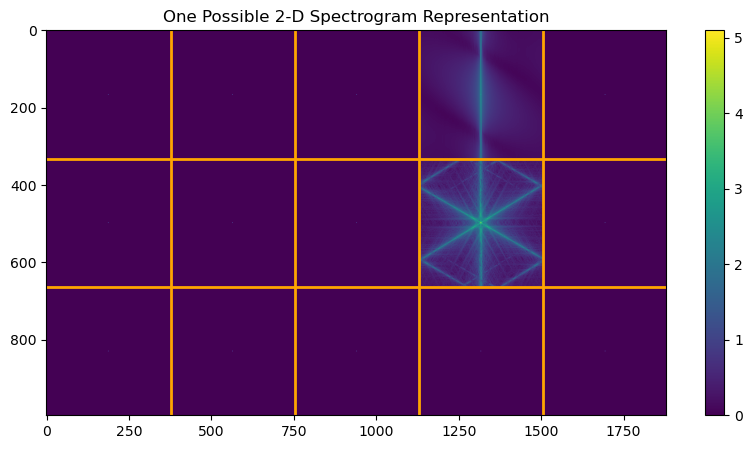

In [52]:
box_height = sticker.shape[0]
box_width = sticker.shape[1]

# Create an empty composite array
composite_dft = np.zeros_like(padded_image1)

total_height = composite_dft.shape[0]
total_width = composite_dft.shape[1]

num_boxes_vertically = total_height//box_height
num_boxes_horizontally = total_width//box_width

# Populate the composite array with DFT results
for i in range(num_boxes_vertically):
    for j in range(num_boxes_horizontally):
        # Calculate the index in the list
        idx = i * num_boxes_horizontally + j
        # Place the DFT result in the correct position in the composite array
        composite_dft[
            i * box_height: (i + 1) * box_height,
            j * box_width: (j + 1) * box_width
        ] = get_dft_magnitude(dft1[idx])


plt.figure(figsize=(10, 5))
plt.imshow(composite_dft, cmap='viridis', aspect='auto')
plt.colorbar()
plt.title('One Possible 2-D Spectrogram Representation')
# Calculate the boundaries for the vertical lines (edges of the boxes)
for i in range(1, num_boxes_horizontally):
    plt.axvline(x=i * box_width, color='orange', linestyle='-', linewidth=2)

# Calculate the boundaries for the horizontal lines (edges of the boxes)
for j in range(1, num_boxes_vertically):
    plt.axhline(y=j * box_height, color='orange', linestyle='-', linewidth=2)

plt.show()


## Try with test2

(960, 1708)


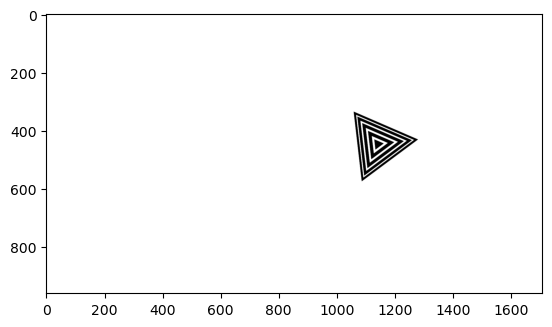

In [24]:
# Load the image
image2 = io.imread('test2.png', as_gray=True)

plt.imshow(image2, cmap="gray")

print(image2.shape)

Correlation coefficient between frequency magnitudes for the 1 box: 0.023191346847976878
Mean Squared Error between magnitude spectra for the 1 box: 0.6681819603766297
Correlation coefficient between frequency magnitudes for the 2 box: 0.023191346847976878
Mean Squared Error between magnitude spectra for the 2 box: 0.6681819603766297
Correlation coefficient between frequency magnitudes for the 3 box: 0.023191346847976878
Mean Squared Error between magnitude spectra for the 3 box: 0.6681819603766297
Correlation coefficient between frequency magnitudes for the 4 box: 0.023191346847976878
Mean Squared Error between magnitude spectra for the 4 box: 0.6681819603766297
Correlation coefficient between frequency magnitudes for the 5 box: 0.023191346847976878
Mean Squared Error between magnitude spectra for the 5 box: 0.6681819603766297
Correlation coefficient between frequency magnitudes for the 6 box: 0.023191346847976878
Mean Squared Error between magnitude spectra for the 6 box: 0.668181960

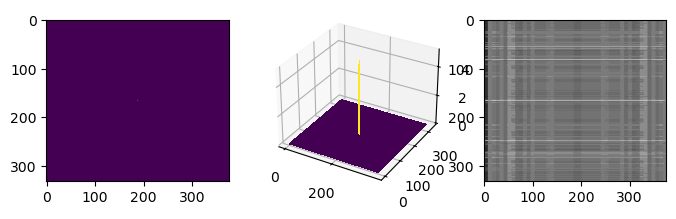

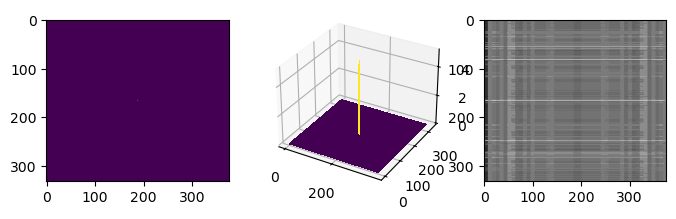

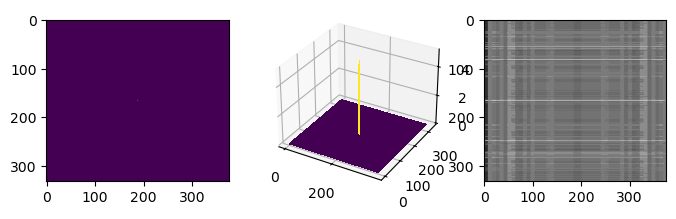

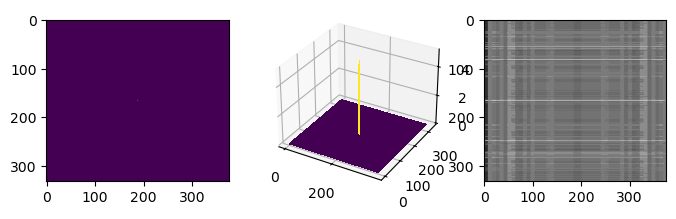

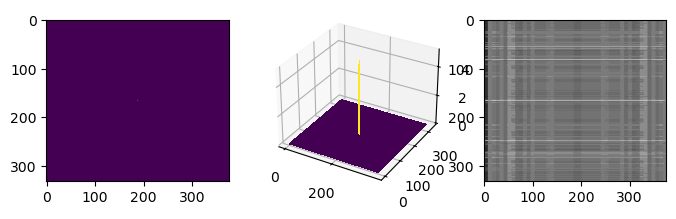

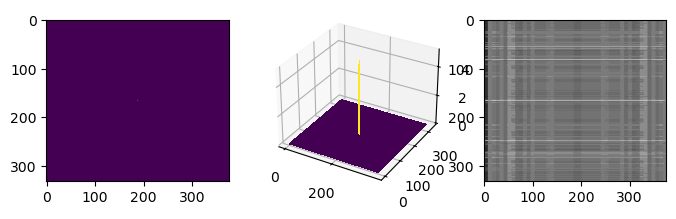

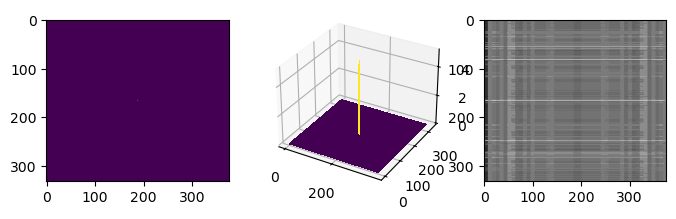

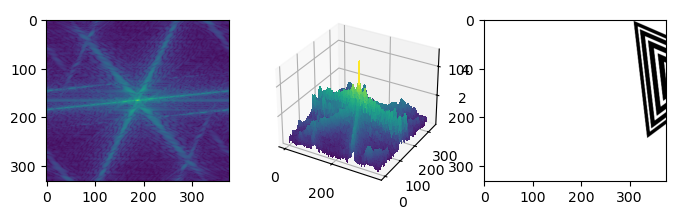

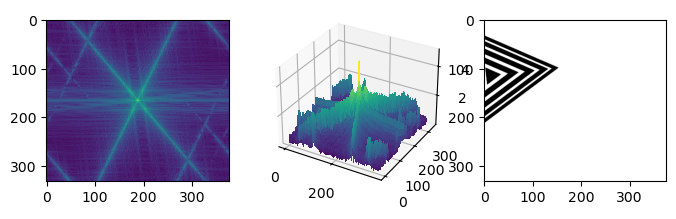

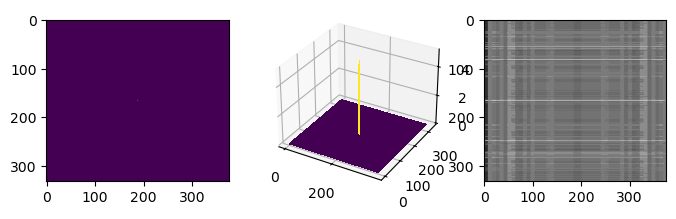

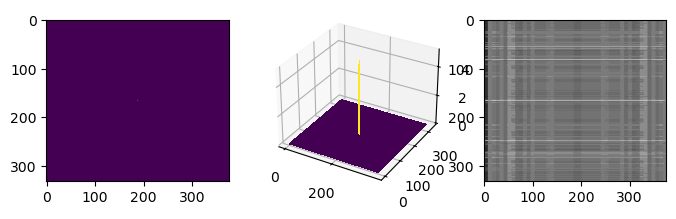

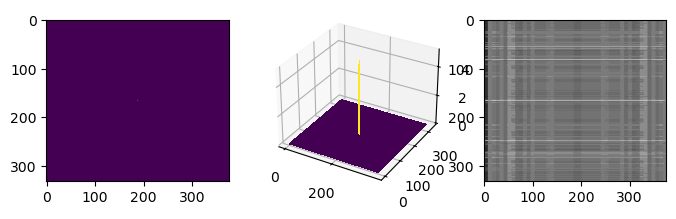

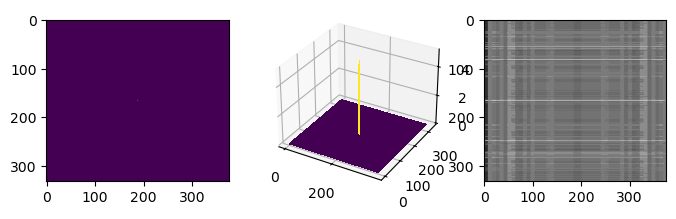

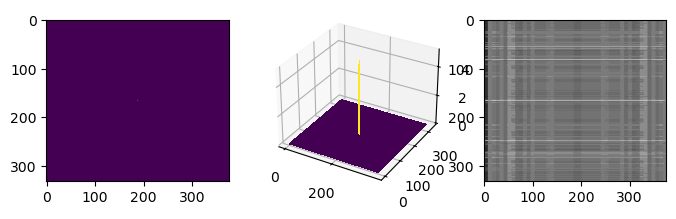

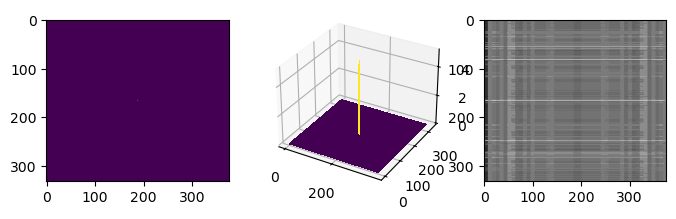

In [44]:
dft2, padded_image2 = display_by_search_box(gray_sticker, image2)

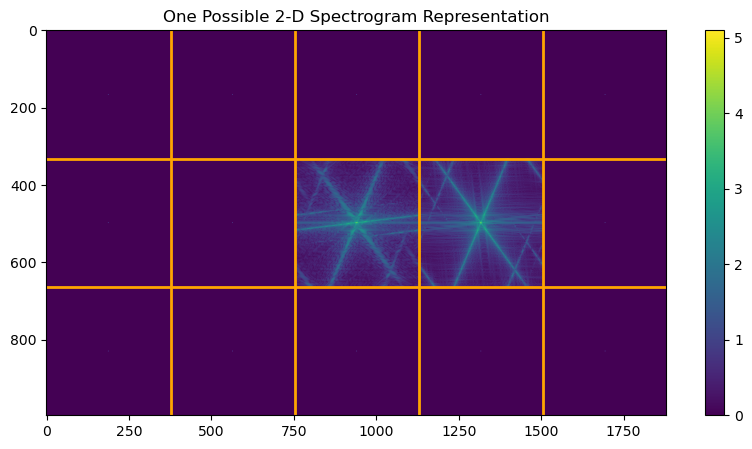

In [53]:
box_height = sticker.shape[0]
box_width = sticker.shape[1]

# Create an empty composite array
composite_dft = np.zeros_like(padded_image2)

total_height = composite_dft.shape[0]
total_width = composite_dft.shape[1]

num_boxes_vertically = total_height//box_height
num_boxes_horizontally = total_width//box_width

# Populate the composite array with DFT results
for i in range(num_boxes_vertically):
    for j in range(num_boxes_horizontally):
        # Calculate the index in the list
        idx = i * num_boxes_horizontally + j
        # Place the DFT result in the correct position in the composite array
        composite_dft[
            i * box_height: (i + 1) * box_height,
            j * box_width: (j + 1) * box_width
        ] = get_dft_magnitude(dft2[idx])


plt.figure(figsize=(10, 5))
plt.imshow(composite_dft, cmap='viridis', aspect='auto')
plt.colorbar()
plt.title('One Possible 2-D Spectrogram Representation')
# Calculate the boundaries for the vertical lines (edges of the boxes)
for i in range(1, num_boxes_horizontally):
    plt.axvline(x=i * box_width, color='orange', linestyle='-', linewidth=2)

# Calculate the boundaries for the horizontal lines (edges of the boxes)
for j in range(1, num_boxes_vertically):
    plt.axhline(y=j * box_height, color='orange', linestyle='-', linewidth=2)

plt.show()


## Try with test3: with noisy background

(960, 1708)


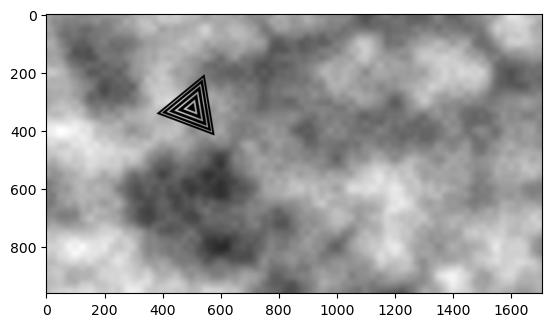

In [54]:
# Load the image
image3 = io.imread('test3.png', as_gray=True)

plt.imshow(image3, cmap="gray")

print(image3.shape)

Correlation coefficient between frequency magnitudes for the 1 box: 0.5535488534081281
Mean Squared Error between magnitude spectra for the 1 box: 0.43735583180193166
Correlation coefficient between frequency magnitudes for the 2 box: 0.4888212750428896
Mean Squared Error between magnitude spectra for the 2 box: 0.2435534252572361
Correlation coefficient between frequency magnitudes for the 3 box: 0.5546286070242814
Mean Squared Error between magnitude spectra for the 3 box: 0.39806221608853387
Correlation coefficient between frequency magnitudes for the 4 box: 0.5606591523098209
Mean Squared Error between magnitude spectra for the 4 box: 0.4003891201228551
Correlation coefficient between frequency magnitudes for the 5 box: 0.5207677663536124
Mean Squared Error between magnitude spectra for the 5 box: 0.4160483341507059
Correlation coefficient between frequency magnitudes for the 6 box: 0.5648641689568187
Mean Squared Error between magnitude spectra for the 6 box: 0.4025006462940728
Co

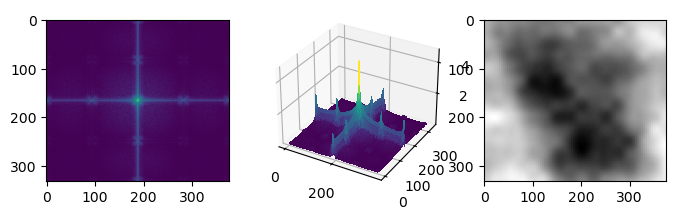

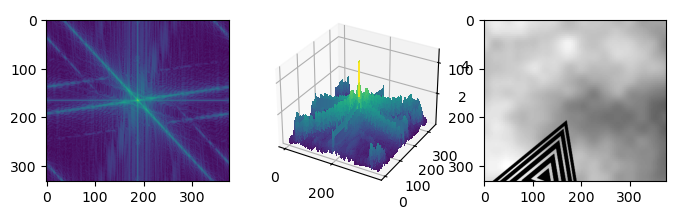

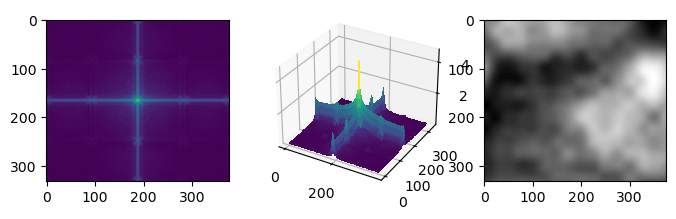

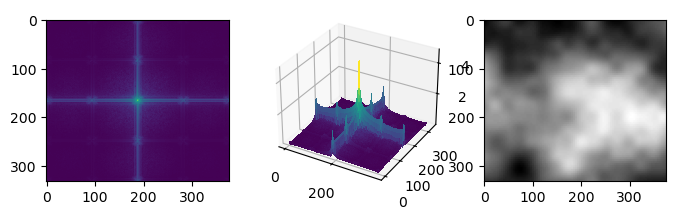

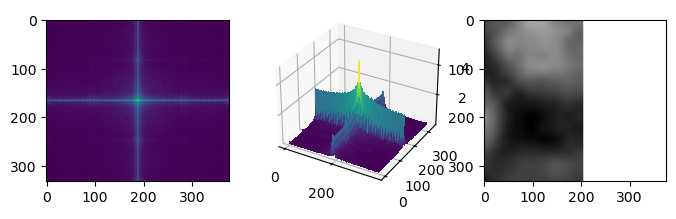

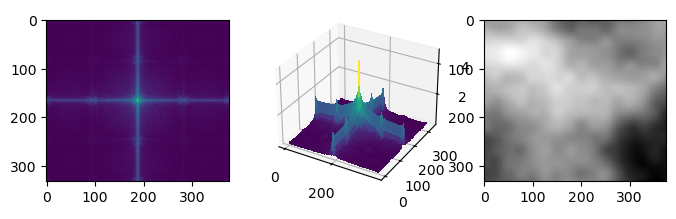

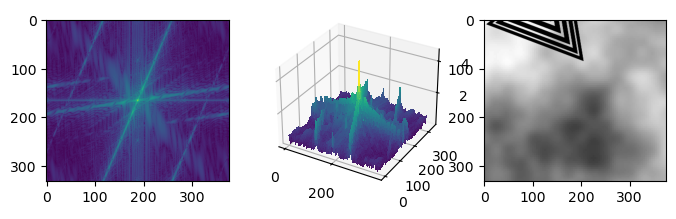

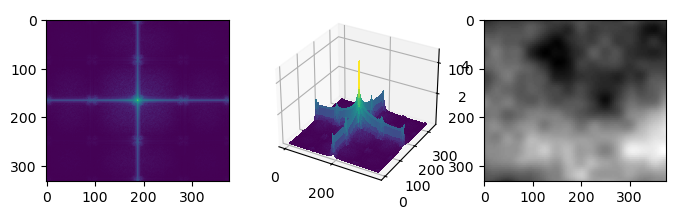

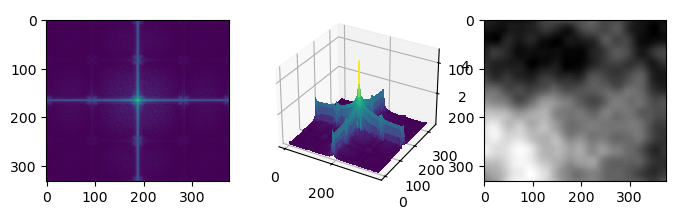

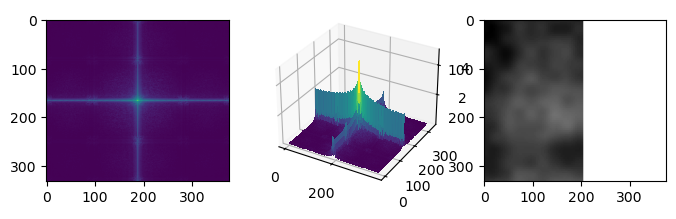

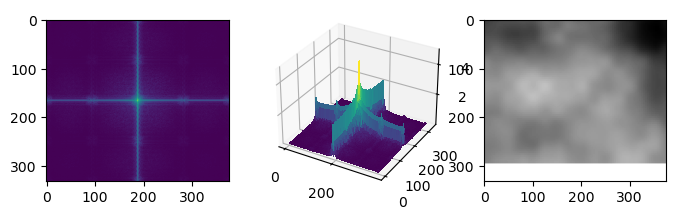

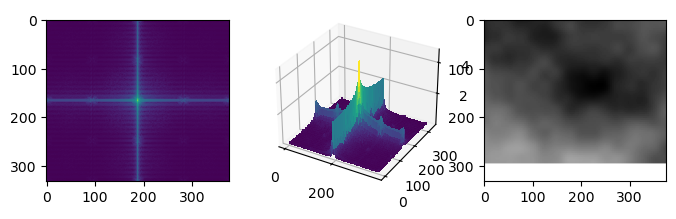

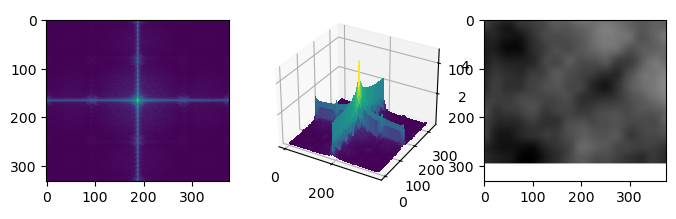

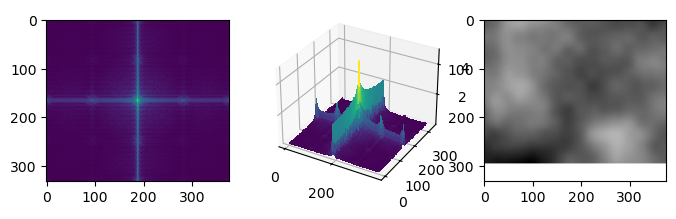

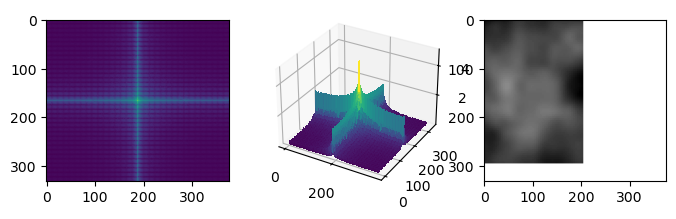

In [55]:
dft3, padded_image3 = display_by_search_box(gray_sticker, image3)

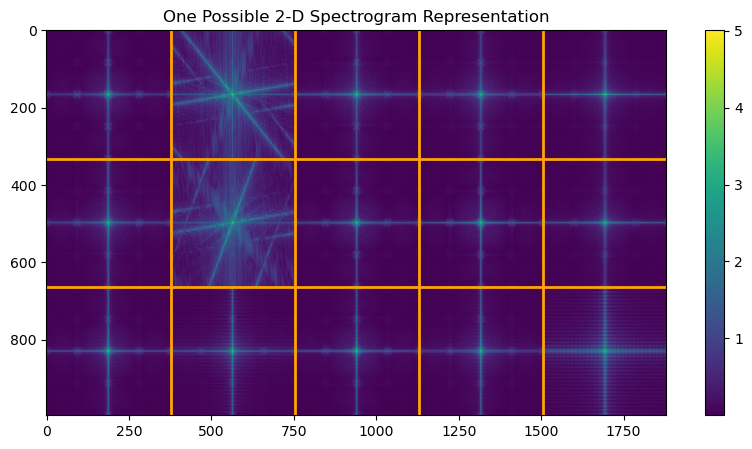

In [56]:
box_height = sticker.shape[0]
box_width = sticker.shape[1]

# Create an empty composite array
composite_dft = np.zeros_like(padded_image3)

total_height = composite_dft.shape[0]
total_width = composite_dft.shape[1]

num_boxes_vertically = total_height//box_height
num_boxes_horizontally = total_width//box_width

# Populate the composite array with DFT results
for i in range(num_boxes_vertically):
    for j in range(num_boxes_horizontally):
        # Calculate the index in the list
        idx = i * num_boxes_horizontally + j
        # Place the DFT result in the correct position in the composite array
        composite_dft[
            i * box_height: (i + 1) * box_height,
            j * box_width: (j + 1) * box_width
        ] = get_dft_magnitude(dft3[idx])


plt.figure(figsize=(10, 5))
plt.imshow(composite_dft, cmap='viridis', aspect='auto')
plt.colorbar()
plt.title('One Possible 2-D Spectrogram Representation')
# Calculate the boundaries for the vertical lines (edges of the boxes)
for i in range(1, num_boxes_horizontally):
    plt.axvline(x=i * box_width, color='orange', linestyle='-', linewidth=2)

# Calculate the boundaries for the horizontal lines (edges of the boxes)
for j in range(1, num_boxes_vertically):
    plt.axhline(y=j * box_height, color='orange', linestyle='-', linewidth=2)

plt.show()
